# Cart Problem no integral #

Ipopt 3.12.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3604
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      843
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

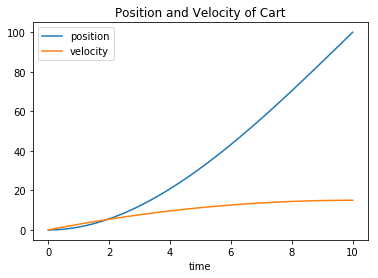

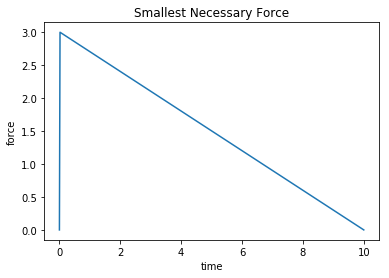

In [3]:
from pyomo.environ import *
from pyomo.dae import *

model = ConcreteModel()

#time
model.t = ContinuousSet(bounds=(0,10))

#mass
model.M = 1

#unknown functions
model.u = Var(model.t, initialize = 0)
model.f1 = Var(model.t)
model.f2 = Var(model.t)
model.myobj = Var(model.t)

#derivatives
model.df1dt = DerivativeVar(model.f1, wrt = model.t)
model.df2dt = DerivativeVar(model.f2, wrt = model.t)
model.dmyobjdt = DerivativeVar(model.myobj, wrt = model.t)

#objective
model.obj = Objective(expr = model.myobj[10])

#constraint b
def velo(model, t):
    if t == 0:
        return Constraint.Skip
    return model.df1dt[t] == model.f2[t]
model.consb = Constraint(model.t, rule = velo)

#constraint c
def accel(model, t):
    if t == 0:
        return Constraint.Skip
    return model.df2dt[t] == model.u[t] / model.M
model.consc = Constraint(model.t, rule = accel)    
#objective constraint

def objcond(model, t):
    if t == 0:
        return Constraint.Skip
    return model.dmyobjdt[t] == (model.u[t])**2
model.objcons = Constraint(model.t, rule = objcond)

#constraint d/e
def initcond1(model):
    yield model.f1[0] == 0
    yield model.f2[0] == 0
    yield model.f1[10] == 100
    yield model.myobj[0] == 0
    yield ConstraintList.End
model.consd1 = ConstraintList(rule = initcond1)

# Discretize model using Backward Finite Difference method
#discretizer = TransformationFactory('dae.finite_difference')
#discretizer.apply_to(model, nfe=20, scheme='BACKWARD')

# Discretize model using Orthogonal Collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(model, nfe=20, ncp=6, scheme='LAGRANGE-RADAU')



solver=SolverFactory('ipopt')

results = solver.solve(model,tee=True)

f1 = []
f2 = []
u = []
t=[]

#print(sorted(model.t))

for i in sorted(model.t):
    t.append(i)
    f1.append(value(model.f1[i]))
    f2.append(value(model.f2[i]))
    u.append(value(model.u[i]))

import matplotlib.pyplot as plt

plt.plot(t,f1)
plt.plot(t,f2)
plt.legend(['position','velocity'])
plt.title('Position and Velocity of Cart')
plt.xlabel('time')
plt.show()

plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')
plt.title('Smallest Necessary Force')
plt.show()
